<a href="https://colab.research.google.com/github/abeersethia/CCM_EEG/blob/main/LorenzReconstructionUsing1Dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
torch.manual_seed(0)
np.random.seed(0)

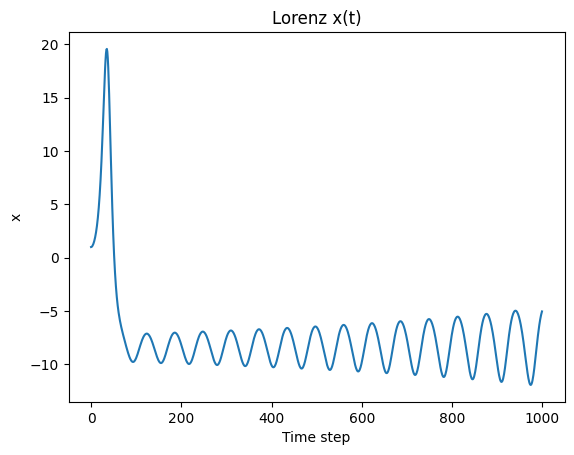

In [129]:
def generate_lorenz(n_steps=10000, dt=0.01, x0=[1.0, 1.0, 1.0]):
    def lorenz(state, t, sigma=10, rho=28, beta=8/3):
        x, y, z = state
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return [dx, dy, dz]

    t = np.arange(0, n_steps * dt, dt)
    states = odeint(lorenz, x0, t)
    return states[:, 0]  # return x(t)

signal = generate_lorenz()
plt.plot(signal[:1000])
plt.title("Lorenz x(t)")
plt.xlabel("Time step")
plt.ylabel("x")
plt.show()

In [130]:
def build_hankel(signal, T):
    return np.array([signal[i:i+T] for i in range(len(signal) - T)])

T = 30  # lag window size
X = build_hankel(signal, T)
X_tensor = torch.tensor(X, dtype=torch.float32)

In [131]:
# MLP AUTOENCODER
class MLPAutoencoderTorch(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent


In [132]:
def compute_fnn_loss(Y, K=5, scale=1.5):
    B, L = Y.shape
    loss = 0.0
    for m in range(2, L):
        # Subspaces Y[:, :m] and Y[:, :m+1]
        Y_m = Y[:, :m]
        Y_m1 = Y[:, :m+1]

        # Compute pairwise distances
        dist_m = torch.cdist(Y_m, Y_m)
        dist_m1 = torch.cdist(Y_m1, Y_m1)

        # Get indices of K nearest neighbors (excluding self)
        knn_indices = torch.topk(dist_m, K + 1, largest=False).indices[:, 1:]  # shape: [B, K]

        # Gather dists in current and next dimension
        dists_m = torch.gather(dist_m, 1, knn_indices)
        dists_m1 = torch.gather(dist_m1, 1, knn_indices)

        # Compare neighbors retained
        retained = (dists_m1 < dists_m * scale).float()
        F_bar = retained.mean().item()

        # Variance penalty
        var_m = torch.var(Y[:, m])
        loss += (1.0 - F_bar) * var_m
    return loss

In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
T = X_tensor.shape[1]  # input dim from Hankel
L = 10                 # latent space dimension
lambda_fnn = 2e-2      # adjust this to sweep (try 1e-2, 5e-2, 1e-1)
num_epochs = 300

# Normalising input
X_tensor = (X_tensor - X_tensor.mean()) / X_tensor.std()

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = X_tensor.to(device)

# Initialize model
model = MLPAutoencoderTorch(input_dim=T, latent_dim=L).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Logs
recon_history = []
fnn_history = []

print(f"\nTraining with λ = {lambda_fnn:.0e}")

for epoch in range(num_epochs):
    model.train()
    X_hat, Y_latent = model(X_tensor)

    recon_loss = loss_fn(X_hat, X_tensor)
    fnn_loss = compute_fnn_loss(Y_latent[:2000])  # crop for speed

    total_loss = recon_loss + lambda_fnn * fnn_loss
    total_loss.backward()

    # Gradient clipping - Optional?
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

    optimizer.step()
    optimizer.zero_grad()

    # ReduceLR based on total loss
    scheduler.step(total_loss.item())

    # Logging
    recon_history.append(recon_loss.item())
    fnn_history.append(fnn_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Recon Loss: {recon_loss.item():.4f} | FNN Loss: {fnn_loss.item():.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training with λ = 2e-02
Epoch 000 | Recon Loss: 1.0117 | FNN Loss: 0.0021
Epoch 010 | Recon Loss: 0.9824 | FNN Loss: 0.0135
Epoch 020 | Recon Loss: 0.8696 | FNN Loss: 0.0585
Epoch 030 | Recon Loss: 0.5490 | FNN Loss: 0.7098
Epoch 040 | Recon Loss: 0.2876 | FNN Loss: 2.1594
Epoch 050 | Recon Loss: 0.1918 | FNN Loss: 2.3963
Epoch 060 | Recon Loss: 0.1630 | FNN Loss: 1.1651
Epoch 070 | Recon Loss: 0.1520 | FNN Loss: 0.6498
Epoch 080 | Recon Loss: 0.1489 | FNN Loss: 0.1598
Epoch 090 | Recon Loss: 0.1460 | FNN Loss: 0.0344
Epoch 100 | Recon Loss: 0.1428 | FNN Loss: 0.0208
Epoch 110 | Recon Loss: 0.1370 | FNN Loss: 0.0198
Epoch 120 | Recon Loss: 0.1228 | FNN Loss: 0.0180
Epoch 130 | Recon Loss: 0.0899 | FNN Loss: 0.0215
Epoch 140 | Recon Loss: 0.0490 | FNN Loss: 0.0338
Epoch 150 | Recon Loss: 0.0267 | FNN Loss: 0.0317
Epoch 160 | Recon Loss: 0.0208 | FNN Loss: 0.0301
Epoch 170 | Recon Loss: 0.0169 | FNN Loss: 0.0327
Epoch 180 | Recon Loss: 0.0143 | FNN Loss: 0.0306
Epoch 190 | Recon Loss: 0

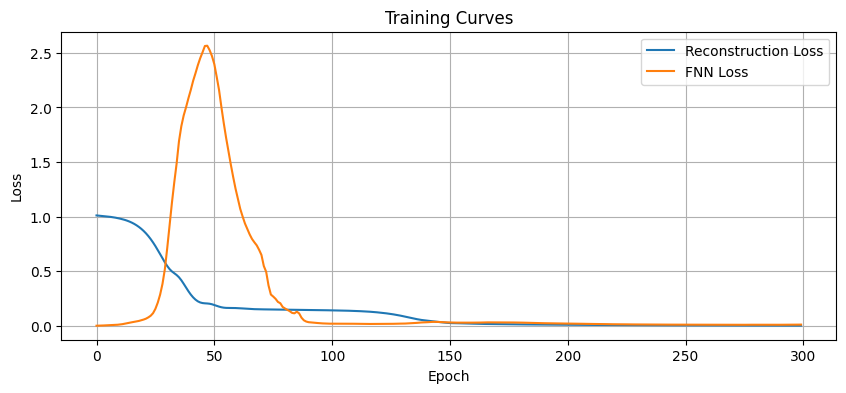

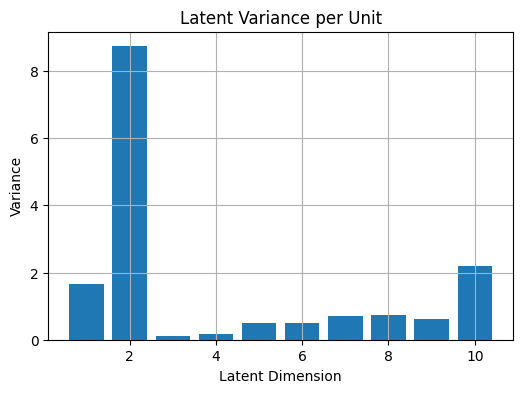

In [134]:
# Plot Results
# Loss curves
plt.figure(figsize=(10, 4))
plt.plot(recon_history, label="Reconstruction Loss")
plt.plot(fnn_history, label="FNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves")
plt.legend()
plt.grid(True)
plt.show()

# Latent Variance Plot
with torch.no_grad():
    _, Y_latent_final = model(X_tensor)
    latent_var = torch.var(Y_latent_final, dim=0).cpu().numpy()

plt.figure(figsize=(6, 4))
plt.bar(range(1, L+1), latent_var)
plt.title("Latent Variance per Unit")
plt.xlabel("Latent Dimension")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

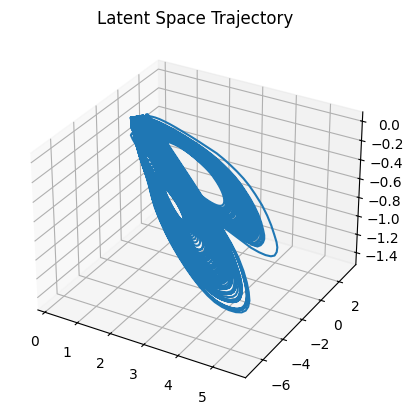

In [135]:
with torch.no_grad():
    _, Y_latent = model(X_tensor)
    Y_latent_np = Y_latent.cpu().numpy()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Y_latent_np[:,0], Y_latent_np[:,1], Y_latent_np[:,2])
ax.set_title("Latent Space Trajectory")
plt.show()